In [2]:
import numpy as np
import pandas as pd     
import matplotlib.pyplot as plt 

import pykat.optics.maps as pkm
from pykat import finesse                 
from pykat.commands import *               
from pykat.optics.maps import *            
from scipy.special import factorial
import fileinput

%config InlineBackend.figure_format='svg'
%matplotlib inline
pykat.init_pykat_plotting(dpi=90)

                                              ..-
    PyKat 1.2.1           _                  '(
                          \`.|\.__...-""""-_." )
       ..+-----.._        /  ' `            .-'
   . '            `:      7/* _/._\    \   (
  (        '::;;+;;:      `-"' =" /,`"" `) /
  L.        \`:::a:f            c_/     n_'
  ..`--...___`.  .    ,
   `^-....____:   +.      www.gwoptics.org/pykat



## Content:
This file is about generating random maps with the layer coefficients provided by the aLIGO measured map 'ETM05_S1_finesse'

In [7]:
# Create a list of Zernike basis to form the random maps
def Zernikebasis(shape, radius, step_size, max_zern=10):
    center = (shape-1)/2
    rrange = radius/step_size
    zernikes=[]
    def theta(x,y):
        phi = np.arctan2(y, x)
        return phi
    
    def radial(x,y,n,m):
        if m<0:
            m=-m
        sum=0
        for k in range(int((n-m)/2)+1):   
            r=(-1)**k*factorial(n-k)/factorial(k)/factorial((n+m)/2-k)/factorial((n-m)/2-k)*((x**2+y**2)/(rrange**2))**(n/2-k)
            sum+=r
        return sum

    def angular(x,y,n,m): 
        a=theta(x,y)
        if m>=0:
            angular=np.cos(m*a)
        else:
            angular=-np.sin(m*a)
        return angular
    
    for n in range(max_zern):
        for m in range(-n,n+1,2):
            stepRange = np.arange(shape)-center
            x,y=np.meshgrid(stepRange,stepRange,sparse=True)
            zfunc=radial(x,y,n,m)*angular(x,y,n,m)
            for i in range(shape):
                for j in range(shape): 
                    if (i-center)**2+(j-center)**2>= rrange**2:
                        zfunc[i][j]=0
            zmap=zfunc/np.abs(zfunc).max()
            zernikes.append(zmap)
    return zernikes

# Create a conversion between {n}{m} to {i}
i=0
dic={} 
for n in range(10):
    for m in range(-n,n+1,2):
        dic[f'{n}{m}']=i
        i=i+1

# Calculate the random coefficients with the same layer coefficients as coeff, which is set to be the map'ETM05_S1_finesse' later
def randomCoeff(coeff, max_zern=10):
    randomCoeff=np.random.rand(55)-0.5 # First create random numbers
    norm=[]
    for n in range(max_zern):
        squ_sum=0
        for m in range(-n,n+1,2):
            index=dic[f'{n}{m}']
            if n==2 and m==0:
                continue
            else:
                squ_sum+=randomCoeff[index]**2
        norm.append(np.sqrt(squ_sum)) # Calculate the 'norm' at each layer

    for n in range(max_zern):
        for m in range(-n,n+1,2):
            index=dic[f'{n}{m}']
            if n==2 and m==0:
                randomCoeff[index]=0
            else:
                randomCoeff[index]=coeff[n]*randomCoeff[index]/norm[n] # The random Zernike coefficients are normalized
                # by the norm and the required layer coefficients 'coeff'. In this way the new random Zernike coefficients
                # are both random and have the same layer coefficient as 'coeff'
    return randomCoeff

# Create a list of Zernike basis
basis=Zernikebasis(shape=1131, radius=0.15, step_size=0.0002669951063580811)

def randommaps(coeff):
    coeffs=randomCoeff(coeff=coeff)
    random_map=0
    for i in range(55):
            random_map+=basis[i]*coeffs[i] # A linear combination of the zernike basis with the random zernike coefficients
            # calculated in function 'randomCoeff'
    return random_map

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


In [4]:
# add the file header to generate a map
def insert(originalfile,string):
    with open(originalfile,'r') as f:
        with open('temp.txt','w') as f2: 
            f2.write(string)
            f2.write(f.read())
    os.rename('temp.txt',originalfile)

def mapfileheader(filename, mapdata):
    with open('Znmmaps/Z00order1phasemap.txt') as myfile: # take the header from an existing map
        head = [next(myfile) for x in range(9)]
    header="".join(head)

    np.savetxt(filename, mapdata, delimiter=' ',fmt='%1.4f') # Save the mapdate along with the map header
    insert(filename,f'''{header}''')

In [9]:
# Code testing: generate a random map called 'testing.txt' with layer coefficients [0,0,1,2,3,4,5,6,7,8]
# 'testing.txt' will be decomposed in file 'Layer coefficients calculation for aLIGO measured maps'
# The calculated layer coefficients should be close to what set here [0,0,1,2,3,4,5,6,7,8]
testing = randommaps(coeff = [0,0,1,2,3,4,5,6,7,8])
mapfileheader('testing.txt', testing)

In [8]:
# This is from the calculation in 'Layer coefficients calculation for aLIGO measured maps'
random_Coeffs = [0, 0, 0.20190713375335292, 0.1458974321372058, 0.13728131907327343, 0.0647602622253127,
 0.0639643843456696, 0.06163558192765335, 0.11786865519746435, 0.10733282124903537]


# CNNdata=[] # This is for CNN
for i in range(100): # Generate 100 random maps from the map ETM05_S1_finesse
    mapdata = randommaps(coeff = random_Coeffs)
#    CNNdata.append(mapdata) # this is for CNN deep learning task
    mapfileheader(f'randommaps/randommap{i}.txt', mapdata)
    
#pd.Series(CNNdata).to_pickle('pkl/500CNNmapsinput.pkl')

/opt/anaconda3/lib/python3.7/site-packages/pykat/optics/maps.py:476: MatplotlibDeprecationWarning: 
The set_clim function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use ScalarMappable.set_clim instead.
  cbar.set_clim(zmin, zmax)


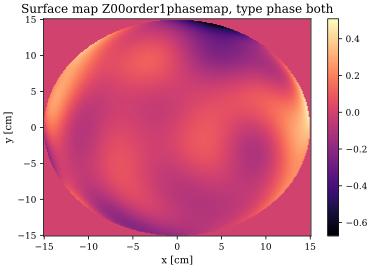

In [3]:
# One example random map
smap=pkm.read_map('randommaps/randommap0.txt', mapFormat='finesse')
fig1 = smap.plot()
fig1.savefig('../randommaps.pdf')